
3.Implement Image classification using convolutional neural networks (CNNs) for multiclass
classification.



In [1]:
#  imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
# load MNIST dataset
# MNIST is small and included in Keras datasets.
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)
# Example: x_train shape = (60000, 28, 28)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train: (60000, 28, 28) y_train: (60000,)
x_test: (10000, 28, 28) y_test: (10000,)


In [3]:
#  preprocessing
# 1) Normalize pixels to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# 2) Add channel dimension (needed by Conv2D): (28,28) -> (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

# 3) Convert labels to one-hot vectors (since we'll use categorical_crossentropy).
num_classes = 10
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("After preprocess x_train:", x_train.shape, "y_train_cat:", y_train_cat.shape)


After preprocess x_train: (60000, 28, 28, 1) y_train_cat: (60000, 10)


In [4]:
# define CNN model
def create_model(input_shape=(28,28,1), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')          # softmax for multiclass
    ])
    # compile: optimizer, loss, metrics
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = create_model()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,778 (4.58 MB)

 Trainable params: 1,200,330 (4.58 MB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
# Cell 6 — callbacks and training
# EarlyStopping: stop training when val_loss doesn't improve
# ModelCheckpoint: save best model by validation accuracy
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_mnist_cnn.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    x_train, y_train_cat,
    epochs=8,
    batch_size=128,
    validation_split=0.1,     # 10% of train used as validation
    callbacks=[es, mc],
    verbose=2
)


Epoch 1/8
422/422 - 160s - 379ms/step - accuracy: 0.9894 - loss: 0.0317 - val_accuracy: 0.9907 - val_loss: 0.0305
Epoch 2/8
422/422 - 203s - 482ms/step - accuracy: 0.9902 - loss: 0.0292 - val_accuracy: 0.9903 - val_loss: 0.0350
Epoch 3/8
422/422 - 202s - 479ms/step - accuracy: 0.9924 - loss: 0.0241 - val_accuracy: 0.9913 - val_loss: 0.0309
Epoch 4/8
422/422 - 160s - 380ms/step - accuracy: 0.9928 - loss: 0.0222 - val_accuracy: 0.9917 - val_loss: 0.0309


In [9]:
#  evaluate on test set (load best weights first)
model.load_weights('best_mnist_cnn.h5')
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=2)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


313/313 - 7s - 22ms/step - accuracy: 0.9894 - loss: 0.0336
Test loss: 0.03359800577163696
Test accuracy: 0.9894000291824341


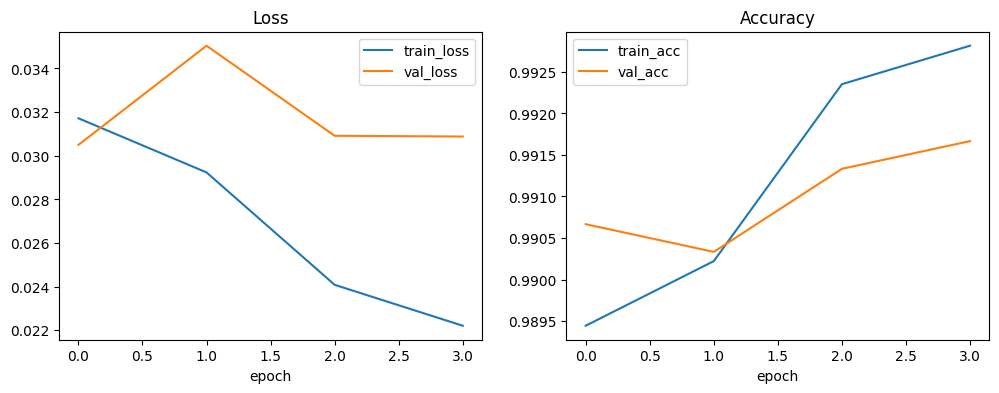

In [10]:
#  plot training curves (loss & accuracy)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



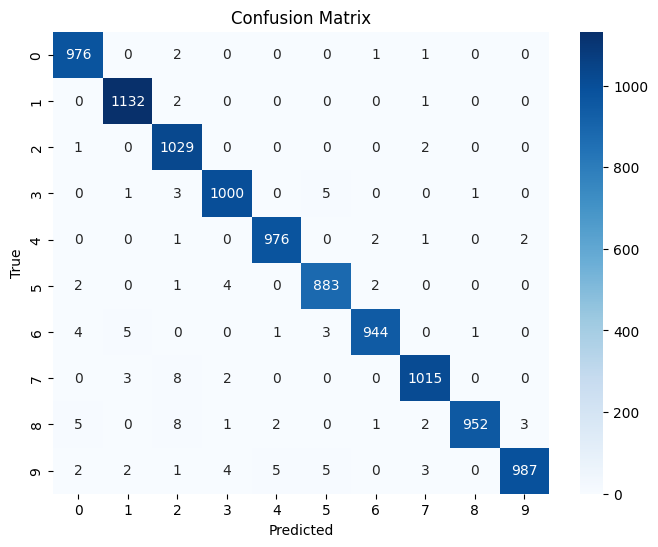

In [11]:
# classification report & confusion matrix
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Classification report:")
print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Saving image-3.jpg to image-3 (2).jpg


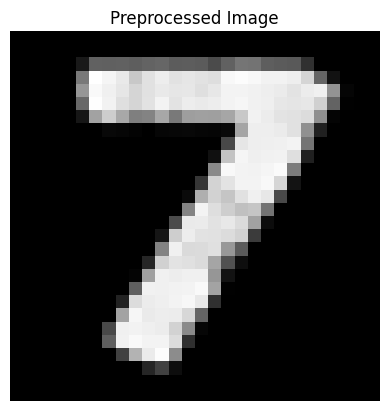

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted digit: 7


In [15]:
from google.colab import files
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Upload image
uploaded = files.upload()

for filename in uploaded.keys():
    # Load as grayscale
    img = Image.open(filename).convert('L')

    # Invert so background is black and digit is white (like MNIST)
    img = ImageOps.invert(img)

    # Resize to 28x28
    img = img.resize((28,28))

    # Convert to numpy and normalize
    img_array = np.array(img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=(0,-1))  # shape (1,28,28,1)

    # Show preprocessed image
    plt.imshow(img_array.squeeze(), cmap='gray') # Apply squeeze to the numpy array
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()

    # Predict
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    print(f"Predicted digit: {predicted_class}")